In [1]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm

from torchvision import datasets
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

import matplotlib.pyplot as plt
import numpy as np
import random

## device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## model

In [3]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=2)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [4]:
config = timm.data.resolve_data_config({}, model=model)
config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

## Data

In [5]:
train_transform = timm.data.transforms_factory.create_transform(
    **config,
    is_training=True,
)

val_transform = timm.data.transforms_factory.create_transform(
    **config,
    is_training=False
)

In [6]:
train_data = datasets.ImageFolder("split_dataset/train", transform=train_transform)
val_data = datasets.ImageFolder("split_dataset/val", transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

## Train

In [8]:
acc = MulticlassAccuracy(num_classes=2).to(device)
F1_score = MulticlassF1Score(num_classes=2).to(device)

num_epochs = 2
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

for epoch in range(num_epochs) :
    model.train()
    train_loss = 0

    train_loop = tqdm(train_loader, desc=f'Epoch {epoch + 1} / {num_epochs} [TRAINING]', leave=False)
    for image, labels in train_loop :
        image, labels = image.to(device) , labels.to(device).long()

        optimizer.zero_grad()
        preds = model(image)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()

        loss+=loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    avg_train_loss = train_loss / len(train_loader)
    model.eval()
    val_loss = 0

    F1_score.reset()
    acc.reset()


    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [VALIDATION]', leave=False)
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device).long()

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            F1_score.update(preds, labels)
            acc.update(preds, labels)
            val_loop.set_postfix(loss=loss.item())
    

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | "
        f"Val Loss: {val_loss/len(val_loader):.4f} | Val F1: {F1_score.compute():.4f} | Val Acc: {acc.compute():.4f}")
    
    scheduler.step()

Epoch 1 / 2 [TRAINING]:  83%|████████▎ | 453/547 [05:41<01:15,  1.25it/s, loss=0.0452] c:\Users\Erfan\.anaconda\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1 | Train Loss: 0.0000 | Val Loss: 0.0200 | Val F1: 0.9931 | Val Acc: 0.9931


Epoch 2 | Train Loss: 0.0000 | Val Loss: 0.0160 | Val F1: 0.9949 | Val Acc: 0.9949


## Test

In [9]:
mean = config['mean']
std = config['std']

def unnormalize(img_tensor):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

In [11]:
def imshow(img_tensor, title=None):
    img = img_tensor.cpu()
    img = unnormalize(img)

    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

In [10]:
test_transform = timm.data.transforms_factory.create_transform(
    **config,
    is_training=False
)

test_data = datasets.ImageFolder("split_dataset/test", transform=test_transform)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

f1: 0.9949319362640381 | accuracy:0.9949317574501038


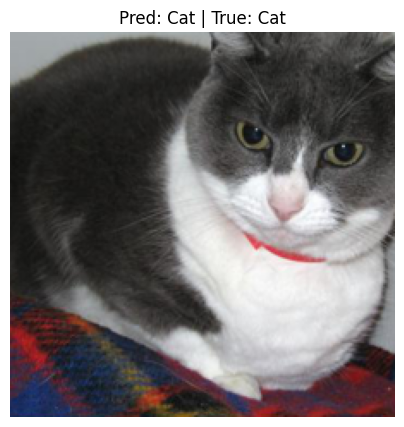

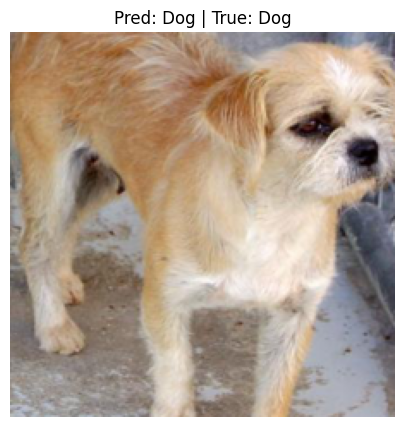

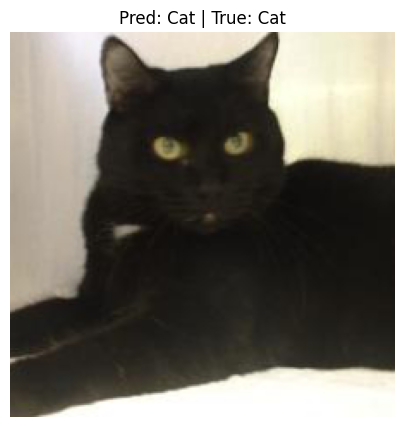

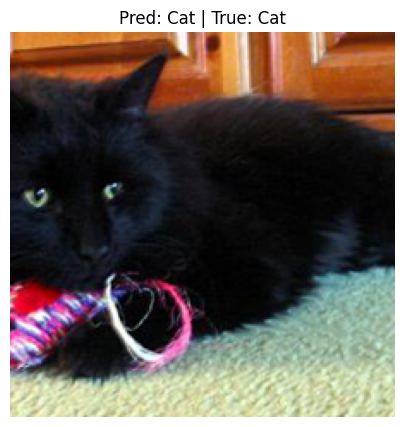

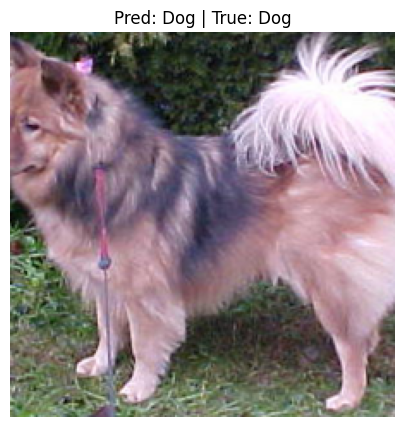

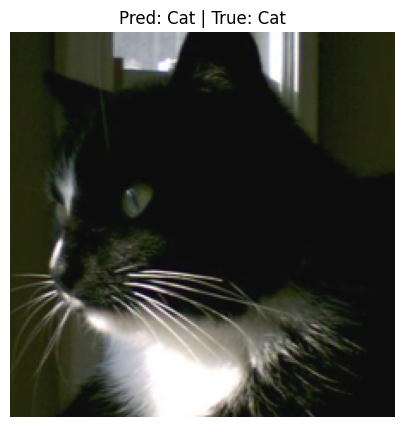

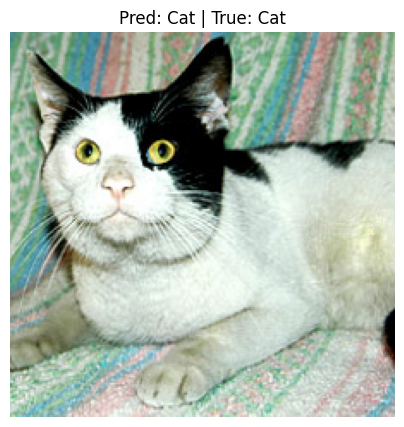

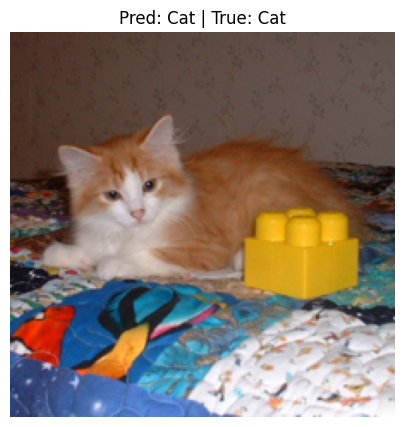

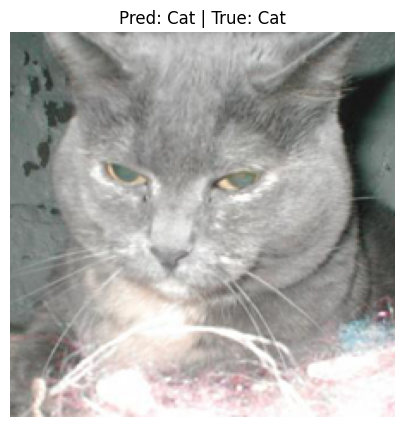

In [13]:
model.eval()
class_names = val_data.classes

all_images = []
all_preds = []
all_labels = []

acc = MulticlassAccuracy(num_classes=2).to(device)
F1_score = MulticlassF1Score(num_classes=2).to(device)

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        preds = model(images)
        _, preds = torch.max(preds, 1)

        F1_score.update(preds, labels)
        acc.update(preds, labels)

        all_images.extend(images.cpu())
        all_preds.extend(preds.cpu())
        all_labels.extend(labels.cpu())

indices = random.sample(range(len(all_images)), 9)

print(f"f1: {F1_score.compute()} | accuracy:{acc.compute()}")

for idx in indices:
    img = all_images[idx]
    pred = all_preds[idx].item()
    true = all_labels[idx].item()

    plt.figure(figsize=(5,5))
    imshow(img, title=f"Pred: {class_names[pred]} | True: {class_names[true]}")
    plt.show()